In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import re
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import emoji

# Global colors
GOOGLE_BLUE = "#4285F4"
GOOGLE_RED = "#DB4437"
GOOGLE_YELLOW = "#F4B400"
GOOGLE_GREEN = "#0F9D58"

import emoji

def get_label(text):
    label = pipe(text)[0]['label']
    if label == "LABEL_1":
        return 1
    return 0

def get_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation = True, max_length = 280)
    output = model(**encoded_input)
    states = output.hidden_states[-1]
    means = np.nanmean(states.detach().numpy(), axis = 1).reshape(1, 768)
    meansdf = pd.DataFrame(means).add_prefix("state_")
    meansdf["text"] = text
    return meansdf
    
    
def is_letters_in_text(text):
    return any(c.isalpha() for c in text)

def remove_unused(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = '' if t.startswith('$') else t
        
        new_text.append(t)
    
    result = " ".join(new_text).strip()
    if result == "" or not is_letters_in_text(result):
        return np.nan
    
    return result

def process_text(texts):

  # remove URLs
    texts = re.sub(r'https?://\S+', "", texts)
    texts = re.sub(r'www.\S+', "", texts)
    # remove '
    texts = texts.replace('&#39;', "'")
    # remove symbol names
    texts = re.sub(r'(\#)(\S+)', r'hashtag_\2', texts)
    texts = re.sub(r'(\$)([A-Za-z]+)', r'cashtag_\2', texts)
    # remove usernames
    texts = re.sub(r'(\@)(\S+)', r'mention_\2', texts)
    # demojize
    texts = emoji.demojize(texts, delimiters=("", " "))
    
    return texts.strip()

MODELPATH = f"zhayunduo/roberta-base-stocktwits-finetuned"
tokenizer = RobertaTokenizer.from_pretrained(MODELPATH)
model = RobertaForSequenceClassification.from_pretrained(MODELPATH , output_hidden_states = True)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
testtext = "bitcoin to the moon!!!"

In [7]:
get_label(testtext)

1

In [8]:
get_embeddings(testtext)

,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,...,state_759,state_760,state_761,state_762,state_763,state_764,state_765,state_766,state_767,text
0,0.002196,0.359157,-0.070619,0.276044,0.126742,0.100316,-0.014287,0.070269,0.212199,-0.414664,...,-0.10516,-0.422657,-0.292035,0.026931,-0.055609,0.022257,0.031579,0.178619,-0.125296,bitcoin to the moon!!!


#### Sentiment

In [10]:
full_tweets = pd.read_csv("data/full_tweets.csv")

In [11]:
full_tweets

,text,time,labels,state_0,state_1,state_2,state_3,state_4,state_5,state_6,...,state_758,state_759,state_760,state_761,state_762,state_763,state_764,state_765,state_766,state_767
0,why are they always in trouble ? Wtfman_shrugg...,2022-01-07 16:07:00,1,0.568612,0.031379,-0.525474,0.030583,-0.136834,1.099880,0.020762,...,-0.867280,0.312184,-0.322063,-1.106938,-0.664763,-0.267377,0.081835,0.984833,1.277146,-0.082719
1,This is a golden opportunity for us multiyear ...,2022-01-07 16:08:00,1,-0.081751,-0.330684,0.130651,-0.880326,-0.261156,2.108410,0.058478,...,0.122367,-0.144062,0.641959,-0.058456,-2.343217,-0.083775,-0.027078,3.194501,0.334293,-0.215795
2,”LETS GO CHINA”!,2022-01-07 16:16:00,1,0.573038,0.020094,-0.474306,0.040019,-0.059309,1.043922,-0.059590,...,-0.891872,0.264671,-0.286227,-1.185368,-0.490861,-0.238890,-0.044781,0.938055,1.245959,-0.120039
3,I was looking for Biden’s live speech he’s mak...,2022-01-07 16:19:00,0,0.115382,0.576235,-0.020420,0.185987,0.027631,0.170377,0.044280,...,-0.074636,-0.064554,0.055036,0.148501,-0.010964,-0.065761,0.165934,-0.098417,-0.054921,0.062249
4,The 3 most manipulated corrupted investments o...,2022-01-07 16:31:00,0,-0.063451,0.965508,0.006462,0.128021,0.195647,-0.331778,-0.095239,...,0.290543,-0.144284,0.581821,0.544725,0.020371,-0.257838,-0.036041,-0.374960,-0.504945,0.651280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19375,why are we still at the same price as when BTC...,2022-02-10 15:46:00,1,0.644843,0.186130,-0.484183,0.061720,-0.437327,1.139251,0.107502,...,-0.836567,-0.096738,-0.415796,-0.987210,-0.701788,-0.355206,0.192086,0.850231,1.113022,-0.210665
19376,BEARISH DIV 1HR,2022-02-10 15:50:00,0,0.195199,1.106008,-0.208558,0.904073,0.303339,-2.171020,0.055922,...,0.190172,0.295580,0.338052,1.073666,1.620079,0.039780,-0.116439,-1.768277,-0.685365,1.111349
19377,Retail supply shock incoming Ripple is buying...,2022-02-10 15:50:00,1,0.338458,-0.470322,-0.265915,-0.652709,-0.200428,2.083731,0.003175,...,-0.298144,0.086143,0.249854,-0.886891,-1.634137,-0.179676,0.099962,2.454239,1.001982,-0.241832
19378,how is this not at. 88 at least? Bitcoin is at...,2022-02-10 15:55:00,0,0.029704,0.871082,0.003597,0.165853,-0.058658,-0.075024,-0.049486,...,0.163478,-0.115471,0.212869,0.330049,-0.093129,-0.256891,0.072514,-0.123542,-0.365509,0.437016


##### Sentiment histogram

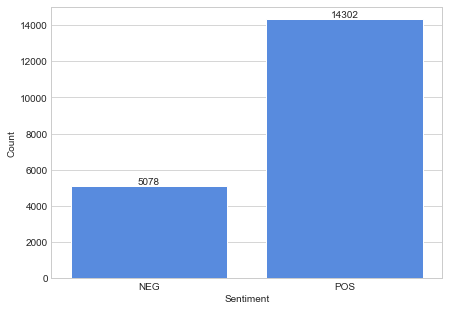

In [12]:
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=full_tweets.groupby(['labels']).size().reset_index(name='counts'),
                 x="labels",
                 y ="counts",
                color=GOOGLE_BLUE)
ax.set(xlabel='Sentiment', ylabel='Count')
ax.set_xticklabels(['NEG', 'POS'])
ax.bar_label(ax.containers[0])
plt.savefig('images/sentiment_barchart.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/sentiment_barchart.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
plt.show()

##### Aggregation

In [13]:
tosum = full_tweets[['time', 'labels']]
tosum["time"] = pd.to_datetime(tosum.time, utc = True) 
tosum["min"] = tosum.time.dt.ceil("min")
tosum["min"] = tosum["min"].dt.tz_localize(None)
tosum["hour"] = tosum.time.dt.ceil("H")
tosum["hour"] = tosum["hour"].dt.tz_localize(None)
tosum["day"] = tosum.time.dt.ceil("D")
tosum["day"] = tosum["day"].dt.tz_localize(None)
tosum["pos"] = [1 if i == 1 else 0 for i in tosum.labels ]
tosum["neg"] = [1 if i == 0 else 0 for i in tosum.labels ]

In [14]:
tosum.head()

,time,labels,min,hour,day,pos,neg
0,2022-01-07 16:07:00+00:00,1,2022-01-07 16:07:00,2022-01-07 17:00:00,2022-01-08,1,0
1,2022-01-07 16:08:00+00:00,1,2022-01-07 16:08:00,2022-01-07 17:00:00,2022-01-08,1,0
2,2022-01-07 16:16:00+00:00,1,2022-01-07 16:16:00,2022-01-07 17:00:00,2022-01-08,1,0
3,2022-01-07 16:19:00+00:00,0,2022-01-07 16:19:00,2022-01-07 17:00:00,2022-01-08,0,1
4,2022-01-07 16:31:00+00:00,0,2022-01-07 16:31:00,2022-01-07 17:00:00,2022-01-08,0,1


In [15]:
def calc_dom(row):
    if row.pos >= row.neg:
        return "Positive"
    return "Negative"

def add_domination(dataset):
    df = dataset.copy()
    df["dom"] = [calc_dom(i) for i in df.itertuples()]
    
    return df

## Minute

In [16]:
minutesum = tosum.groupby('min').sum()
minutesum = minutesum.reset_index()
minutesum = add_domination(minutesum)
minutesum["total"] = minutesum.pos + minutesum.neg
minuteprices = pd.read_csv("raw_data/minute.csv")
minuteprices.time = pd.to_datetime(minuteprices.time,infer_datetime_format = True,  utc = True)
minuteprices.time = minuteprices.time.dt.tz_localize(None)

print("Shape tweets join:", minutesum.shape)
print("Shape prices join:", minuteprices.shape)
minutedf = pd.merge(minuteprices, minutesum, left_on="time", right_on="min", how = 'left')
print("Shape after join:", minutedf.shape)
minutedf = minutedf.drop(['min'], axis = 1)
minutedf = minutedf.fillna(0)
minutedf.to_csv("data/full_minute.csv", index = False)

Shape tweets join: (9177, 6)
Shape prices join: (76312, 6)
Shape after join: (76312, 12)


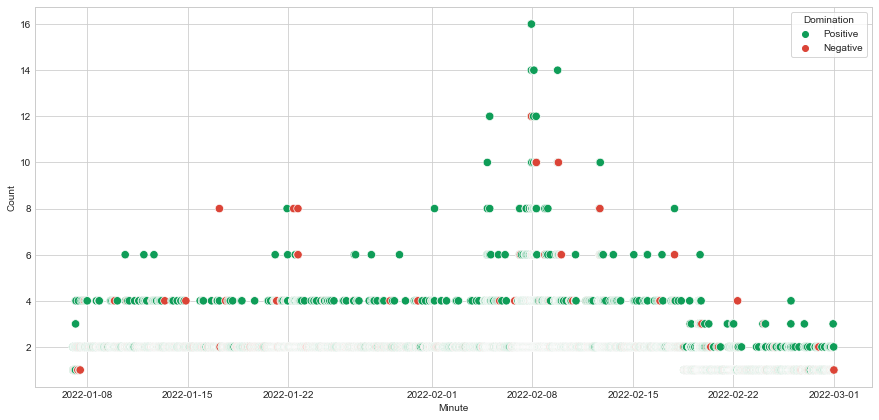

In [17]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(data=minutesum,
                     x="min",
                     y="total",
                     hue = "dom",
                     palette = [GOOGLE_GREEN,  GOOGLE_RED],
                     s = 70
                    )
ax.legend(title = "Domination", frameon = True)

ax.set(xlabel='Minute', ylabel='Count')
plt.savefig('images/minute_scatter_by_domination.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/minute_scatter_by_domination.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
plt.show()


### Hour

In [18]:
hoursum = tosum.groupby('hour').sum()
hoursum = hoursum.reset_index()
hoursum = add_domination(hoursum)
hoursum["total"] = hoursum.pos + hoursum.neg

hourprices = pd.read_csv("raw_data/hour.csv")
hourprices.time = pd.to_datetime(hourprices.time,infer_datetime_format = True,  utc = True)
hourprices.time = hourprices.time.dt.tz_localize(None)
print("Tweets shape:", hoursum.shape)
print("Prices shape:", hourprices.shape)
hourdf = pd.merge(hourprices, hoursum, left_on="time", right_on="hour", how = 'left')
print("Shape after join:", hourdf.shape)
hourdf = hourdf.drop(['hour'], axis = 1)
hourdf = hourdf.fillna(0)
hourdf.to_csv("data/full_hour.csv", index = False)

Tweets shape: (1238, 6)
Prices shape: (1271, 6)
Shape after join: (1271, 12)


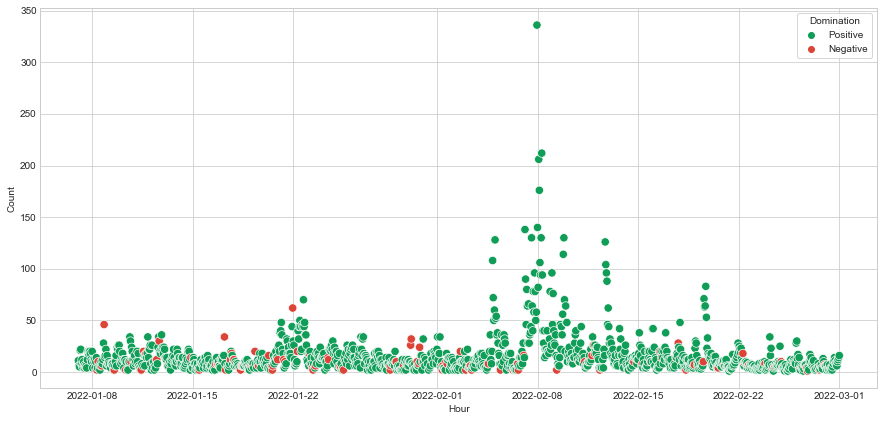

In [19]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(data=hoursum,
                     x="hour",
                     y="total",
                     hue = "dom",
                     palette = [GOOGLE_GREEN, GOOGLE_RED],
                     s = 70
                    )
ax.legend(title = "Domination", frameon = True)

ax.set(xlabel='Hour', ylabel='Count')
plt.savefig('images/hour_scatter_by_domination.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/hour_scatter_by_domination.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
plt.show()

### Day 

In [20]:
daysum = tosum.groupby('day').sum()
daysum = daysum.reset_index()
daysum = add_domination(daysum)
daysum["total"] = daysum.pos + daysum.neg

dayprices = pd.read_csv("raw_data/day.csv")
dayprices.time = pd.to_datetime(dayprices.time,infer_datetime_format = True,  utc = True)
dayprices.time = dayprices.time.dt.tz_localize(None)
print("Tweets shape:", daysum.shape)
print("Prices shape:", dayprices.shape)
daydf = pd.merge(dayprices, daysum, left_on="time", right_on="day", how = 'left')
print("Shape after join:", daydf.shape)
daydf = daydf.drop(['day'], axis = 1)
daydf = daydf.fillna(0)
daydf.to_csv("data/full_day.csv", index = False)

Tweets shape: (53, 6)
Prices shape: (55, 6)
Shape after join: (55, 12)


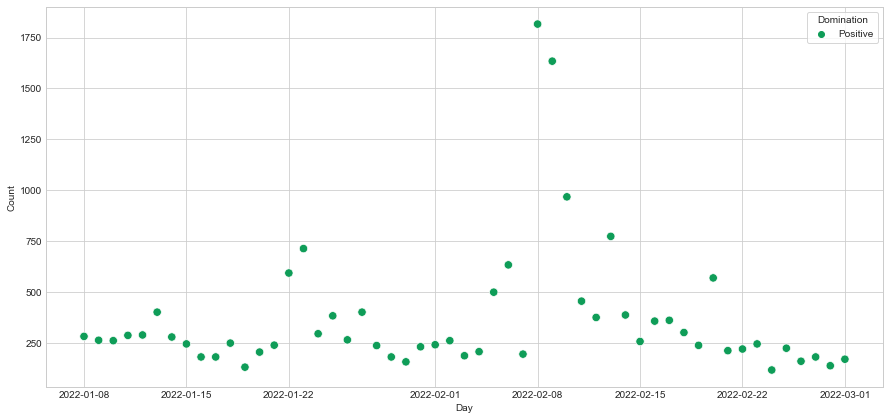

In [21]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(data=daysum,
                     x="day",
                     y="total",
                     hue = "dom",
                     palette = [GOOGLE_GREEN],
                     s = 70
                    )
ax.legend(title = "Domination", frameon = True)

ax.set(xlabel='Day', ylabel='Count')
plt.savefig('images/day_scatter_by_domination.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/day_scatter_by_domination.jpg', format = "jpg", dpi = 300,bbox_inches='tight')

plt.show()
